In [442]:
import os
import random
import numpy as np
import pandas as pd

import cv2
cv2.ocl.setUseOpenCL(False)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer, MinMaxScaler

from mlxtend.plotting import plot_decision_regions
from matplotlib import pyplot as plt
from matplotlib import transforms

from tqdm import tqdm
import re

import tensorflow as tf

#Si vous n'avez pas de GPU ou que vous ne voulez pas l'utiliser, commentez les 2 lignes suivantes
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.preprocessing import image    
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
from tensorflow.keras.models import load_model


LE = LabelEncoder()

from PIL import Image
# from tensorflow.keras.utils import plot_model

2.4.1


In [3]:
os.environ['TF_DETERMINISTIC_OPS'] = '1' #  c'est la ligne la plus importante
os.environ['PYTHONHASHSEED'] = '42'
os.environ['CUDA_VISIBLE_DEVICES'] = '' #  c'est facultatif
os.environ['OPENCV_OPENCL_DEVICE'] = 'disabled'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
data_dir = '../data/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

In [170]:
race_dirs = os.listdir('../data/train')
race_dirs_indexed = LE.fit_transform(race_dirs)
class_names = pd.DataFrame([race_dirs_indexed, race_dirs]).transpose()

In [36]:
def all_images_path(data_type):
    all_images_path = []
    for i in race_dirs:
        folder_path = '../data/' + data_type + '/' + i + '/'
        for u in os.listdir(folder_path):
            all_images_path.append(folder_path + u)
        
    return all_images_path

In [67]:
len(all_images_path('train')) 

16469

In [68]:
len(all_images_path('valid'))

4111

In [11]:
def get_race_from_img_path(img_path):
    full_path_img = os.path.splitext(img_path)[0]
    race = full_path_img.split('/')[3]
    index = class_names[class_names[1] == race].values[0][0]
    return index, race

def display_image(x):
    '''
    function shows images in training set
    INPUT: integer between 0 and 16468
    OUTPUT: image
    '''
    img_path = all_images_path('train')[x]
    img = cv2.imread(img_path)
    index, race = get_race_from_img_path(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    
    return index, race

In [10]:
index, race = get_race_from_img_path(all_images_path('train')[345])
print("{}: {}".format(index, race))

2: n02085936-Maltese_dog


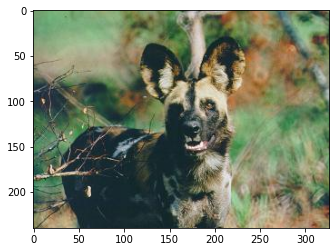

(119, 'n02116738-African_hunting_dog')

In [12]:
display_image(16468)

In [173]:
def load_img(i):
    img = all_images_path('train')[i]
    img = tf.keras.preprocessing.image.load_img(img, target_size=(150, 150))
    return img

#def load_label(i):
    #img_path = all_images_path[i]
    #label_index = train_mat_train_info.labels[i]
    #label_race = class_names[label_index-1]
    
    #return "{} [{}]".format(label_race, label_index)

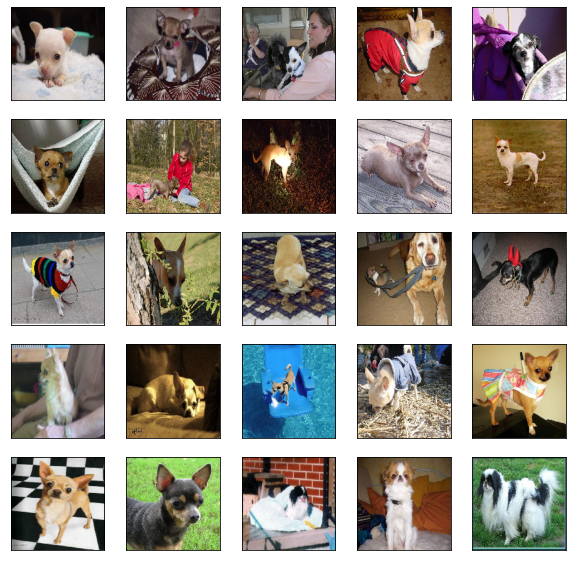

In [175]:
plt.figure(figsize=(10,10))

for i in range(100, 125):
    plt.subplot(5,5,i-100+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(load_img(i))
    
plt.show()

## Preprocessing of the images before training

In [445]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
rescale=1./255,rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [446]:
batch_size=20

In [447]:
train_gen = train_datagen.flow_from_directory(
    '../data/train', 
    target_size=(150, 150), 
    batch_size=batch_size, 
    classes=[*race_dirs]
)

Found 16469 images belonging to 120 classes.


In [448]:
val_gen = val_datagen.flow_from_directory(
    '../data/valid', 
    target_size=(150, 150), 
    batch_size=batch_size, 
    classes=[*race_dirs]
)

Found 4111 images belonging to 120 classes.


In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
imgs, labels = next(val_gen)

In [ ]:
plotImages(imgs)

## Input and Output layers

In [159]:
class_num = len(race_dirs)
print(class_num)

120


In [552]:
inputs = Input(shape=(150, 150, 3))

x = Conv2D(16, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(2)(x)

x = Conv2D(32, 3, activation='relu')(x)
x = MaxPooling2D(2)(x)

x = Conv2D(64, 3, activation='relu')(x)
x = MaxPooling2D(2)(x)
#x = Dropout(0.4)(x)

x = Conv2D(128, 3, activation='relu')(x)
x = MaxPooling2D(2)(x)
#x = Dropout(0.4)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
#x = Dropout(0.4)(x)


outputs = Dense(class_num, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 17, 17, 64)        0  

## Setting model compiler

In [553]:
model.compile(loss='categorical_crossentropy', metrics=['acc'], 
              optimizer='rmsprop')

## Training model

In [554]:
history = model.fit(train_gen, epochs=15, steps_per_epoch=823, 
                   validation_data=val_gen, validation_steps=205)

Epoch 1/15
823/823 [==============================] - 87s 105ms/step - loss: 4.7749 - acc: 0.0126 - val_loss: 4.5322 - val_acc: 0.0351
Epoch 2/15
823/823 [==============================] - 67s 81ms/step - loss: 4.5670 - acc: 0.0295 - val_loss: 4.3469 - val_acc: 0.0483
Epoch 3/15
823/823 [==============================] - 86s 104ms/step - loss: 4.4173 - acc: 0.0400 - val_loss: 4.2042 - val_acc: 0.0676
Epoch 4/15
823/823 [==============================] - 67s 81ms/step - loss: 4.2482 - acc: 0.0589 - val_loss: 3.9881 - val_acc: 0.0890
Epoch 5/15
823/823 [==============================] - 86s 104ms/step - loss: 4.1430 - acc: 0.0702 - val_loss: 4.0569 - val_acc: 0.0824
Epoch 6/15
823/823 [==============================] - 70s 85ms/step - loss: 4.0567 - acc: 0.0813 - val_loss: 3.9082 - val_acc: 0.1002
Epoch 7/15
823/823 [==============================] - 89s 108ms/step - loss: 3.9891 - acc: 0.0889 - val_loss: 3.9845 - val_acc: 0.0910
Epoch 8/15
823/823 [==============================] - 68s 

In [548]:
Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=(150, 150, 3)))

#Xception_model.add(Conv2D(16, (3, 3), activation='relu'))
#x = Conv2D(16, (3, 3), activation='relu')(inputs)
#x = MaxPooling2D(2)(x)
Xception_model.add(Dense(133, activation='softmax'))
Xception_model.add(Flatten())
#x = Flatten()(x)
#x = Dense(512, activation='relu')(x)#
#x = Dropout(0.4)(x)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', verbose = 0, save_best_only=True)

sgd = optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

Xception_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
dense_74 (Dense)             (None, 150, 150, 64)      256       
_________________________________________________________________
flatten_22 (Flatten)         (None, 1440000)           0         
_________________________________________________________________
dense_75 (Dense)             (None, 120)               172800120 
Total params: 172,800,376
Trainable params: 172,800,376
Non-trainable params: 0
_________________________________________________________________


In [549]:
Xception_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [550]:
history = Xception_model.fit(train_gen, epochs=25, steps_per_epoch=823, validation_data=val_gen, validation_steps=205)

Epoch 1/25


InvalidArgumentError:  Incompatible shapes: [20,120] vs. [20,133]
	 [[node categorical_crossentropy/mul (defined at <ipython-input-550-f1472a6aa976>:1) ]] [Op:__inference_train_function_233523]

Function call stack:
train_function


## Accuracy plotting after training

Text(0.5, 1.0, 'Training and validation loss')

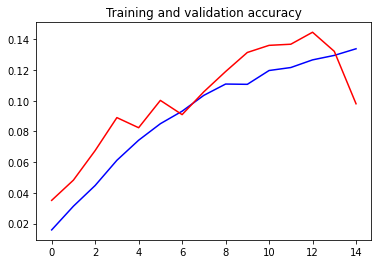

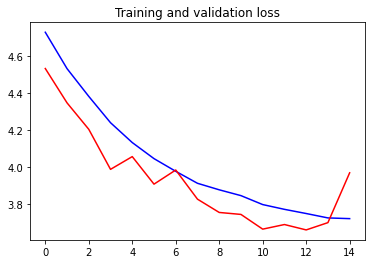

In [567]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, "b", label='accuracy')
plt.plot(epochs, val_acc, "r", label='validation_accuracy')
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, "b", label='loss')
plt.plot(epochs, val_loss, "r", label='validation_loss')
plt.title('Training and validation loss')

## Save model

In [520]:
#model.save('models/dogs_dataset_big.h5')

In [53]:
#model.save('models/dogs_dataset_weird.h5')

In [516]:
#model.save('models/dogs_dataset_big_50_batch.h5')

In [77]:
#model.save('models/dogs_dataset_big_50_batch_2.h5')

In [85]:
#model.save('models/dogs_dataset_big_20_original.h5')

In [503]:
model.save('models/model_25.h5')

In [556]:
#model.save('models/model_15e_1plus_layer.h5')

## Load model

In [573]:
#model = load_model('models/dogs_dataset_big.h5')

In [581]:
#model = load_model('models/dogs_dataset_weird.h5')

In [576]:
#model = load_model('models/dogs_dataset_big_50_batch.h5')

In [571]:
#model = load_model('models/dogs_dataset_big_50_batch_2.h5')

In [416]:
#model = load_model('models/dogs_dataset_big_20_original.h5')

In [590]:
model = load_model('models/model_25.h5')

In [578]:
#model = load_model('models/model_15e_1plus_layer.h5')

## Functions

In [ ]:
#def path_to_tensor_trained_images(img_path):
    # loads RGB image as PIL.Image.Image type
    #img = image.load_img(img_path, target_size=(150, 150, 3))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    #x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    #return np.expand_dims(img, axis=0)
    
#def path_to_tensor_resnet_50(img_path):
    # loads RGB image as PIL.Image.Image type
    #img = image.load_img(img_path, target_size=(224, 224, 3))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    #x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    #return np.expand_dims(img, axis=0)

In [558]:
ResNet50_model = ResNet50(weights='imagenet')

def img_to_tensor_trained_images(img, x, y):
    img = cv2.resize(img, (x, y))
    image_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    image_tensor = tf.expand_dims(image_tensor, 0)
    return image_tensor

def ResNet50_predict_labels(img):
    img = preprocess_input(img_to_tensor_trained_images(img, 224, 224))
    return np.argmax(ResNet50_model.predict(img))

In [559]:
#base = plt.gca().transData
#rot = transforms.Affine2D().rotate_deg(90)

def plot_value_array(predictions_array, true_label):
    #true_label = race_test[i][0]
    plt.grid(False)
    plt.xticks(range(120))
    plt.yticks([0, 1])
    thisplot = plt.bar(x=range(120), height=predictions_array, color="#777777")
    plt.ylim([0, 0.15])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

def dog_detector(img):
    # Detect if an image has a dog or not
    prediction = ResNet50_predict_labels(img)
    return ((prediction <= 268) & (prediction >= 151))

def display_img(img):
    #img = Image.load_img(img)
    img = Image.fromarray(img, 'RGB')
    
    plt.figure(figsize=(5, 5))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)


face_cascade = cv2.CascadeClassifier('../haarcascades/haarcascade_frontalface_alt.xml')

def face_detector(img):
    faces = face_cascade.detectMultiScale(img)
    return len(faces) > 0

def load_img(img_path):
    cv2.ocl.setUseOpenCL(False)
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv_rgb, gray

def format_race(race):
    return re.search(r'^[\w]{9}-(.*)$', race).group(1)

def predict_breed(x, data_type):
    img_path = all_images_path(data_type)[x]
    
    true_race_index, true_race = get_race_from_img_path(img_path) 
    
    cv_rgb, gray = load_img(img_path)
    display_img(cv_rgb)
    
    dog_d = 'No dog found in picture'
    human_d = 'No human found in this picture'
    
    if dog_detector(cv_rgb):
        dog_d = 'Dog found in picture'
        
        single_pred = model.predict(img_to_tensor_trained_images(cv_rgb, 150, 150), 
                                    use_multiprocessing=True)
        
        normalized_data = Normalizer().fit_transform(single_pred)                                                
                                                     
        single_pred_label = np.argmax(single_pred)
        
        predicted_label = format_race(class_names[1][single_pred_label])
        true_label = format_race(true_race)
        
        if predicted_label == true_label:
            color= 'blue'
        else:
            color = 'red'
        
        plt.xlabel("{} {:2.0f}% ({})\n{}\n{}".format(predicted_label, 100*np.max(single_pred), true_label,  dog_d, human_d) , color=color)
        
        newplot = plt.figure(figsize=(25, 15))
        newplot = plt.subplot(4, 1, 1)
        _ = plot_value_array(normalized_data[0], true_race_index)
        _ = plt.xticks(range(120), race_dirs, rotation=90)
        
        if face_detector(gray):
            human_d = 'Human found in this picture'
        
    elif face_detector(gray):
        human_d = 'Human found in this picture'


In [ ]:
face_detector('../data/train/n02085620-Chihuahua/n02085620_11238.jpg')

In [ ]:
dog_detector('../data/train/n02085620-Chihuahua/n02085620_11238.jpg')

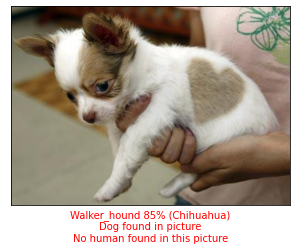

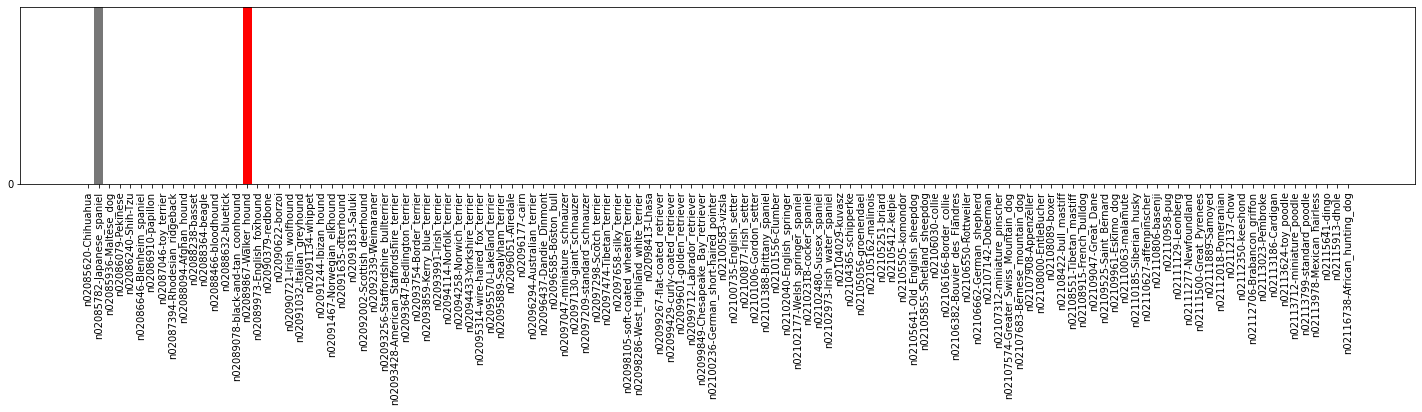

In [591]:
predict_breed(5, data_type='valid')


In [343]:
def predict_breed(img):
 
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    display_img(cv_rgb)
    
    dog_d = 'No dog found in picture'
    human_d = 'No human found in this picture'
    
    if dog_detector(cv_rgb):
        dog_d = 'Dog found in picture'
            
        single_pred = model.predict(img_to_tensor_trained_images(cv_rgb, 150, 150), 
                                    use_multiprocessing=True)
        single_pred_label = np.argmax(single_pred)
        predicted_label = format_race(class_names[1][single_pred_label])
        
        plt.xlabel("{} {:2.0f}% \n{}\n{}".format(predicted_label, 100*np.max(single_pred), dog_d, human_d))
        
        newplot = plt.figure(figsize=(25, 15))
        newplot = plt.subplot(5, 1, 2)
        _ = plot_value_array(single_pred[0], true_race_index)
        _ = plt.xticks(range(120), race_dirs, rotation=90)
        
        if face_detector(gray):
            human_d = 'Human found in this picture'
        
    elif face_detector(gray):
        human_d = 'Human found in this picture'

In [ ]:
def plot_value_array(predictions_array, true_label):
    #true_label =  true_label[i]
    #true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(120))
    plt.yticks([])
    thisplot = plt.bar(x=range(120), height=predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    #thisplot[true_label].set_color('green')

plt.figure(figsize=(25, 15))
plt.subplot(3, 1, 1)
plot_value_array(single_pred[0], race_dirs_indexed)
_ = plt.xticks(range(120), race_dirs, rotation=90)

In [ ]:
train_mat = loadmat('./train_data.mat')
test_mat = loadmat('./test_data.mat')
print(train_mat.keys())
print(test_mat.keys())

In [ ]:
train_mat_train_info = pd.DataFrame(train_mat.get('train_info'))
test_mat_train_info = pd.DataFrame(train_mat.get('test_fg_data'))

In [ ]:
train_mat_train_info

In [ ]:
test_mat_train_info

In [ ]:
for i in train_mat_train_info.columns:
    column = np.array(train_mat_train_info[i].values.tolist())
    train_mat_train_info[i] = column
    
for i in test_mat_train_info.columns:
    column = np.array(test_mat_train_info[i].values.tolist())
    test_mat_train_info[i] = column

In [ ]:
print(train_mat_train_info.columns)
print(test_mat_train_info.columns)

In [ ]:
labels_distinct = train_mat_train_info.drop_duplicates(['labels'])
class_names = []
for i in labels_distinct:
    dog_race = re.match(r'^\w+-(.+)\/\w+$', i).group(1)
    class_names.append(dog_race)
    print(dog_race)

In [ ]:
class_names

In [ ]:
train_mat_train_info = train_mat_train_info.drop_duplicates(['labels'])

In [ ]:
def load_img(i):
    img = "./dogs-dataset-images/" + train_mat_train_info.file_list[i]
    img = tf.keras.preprocessing.image.load_img(img, target_size=(50,50))
    return img

def load_label(i):
    label_index = train_mat_train_info.labels[i]
    label_race = class_names[label_index-1]
    
    return "{} [{}]".format(label_race, label_index)

In [ ]:
plt.figure(figsize=(10,10))

for i in range(100, 125):
    plt.subplot(5,5,i-100+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(load_img(i))
    plt.xlabel(load_label(i))
    
plt.show()